## AirBnB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer

# Models
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config; set_config(display='diagram')

# Custom Transformer 
from sklearn.base import TransformerMixin, BaseEstimator

# Metrics
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
df = pd.read_csv('AB_US_2020.csv')
df.head(1)

C:\Users\perso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville


In [3]:
len(df)

226030

In [4]:
df.dtypes.value_counts()

int64      7
object     7
float64    3
dtype: int64

In [5]:
df.isna().sum()/len(df)*100

id                                 0.000000
name                               0.012388
host_id                            0.000000
host_name                          0.014600
neighbourhood_group               51.252046
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       21.502455
reviews_per_month                 21.502455
calculated_host_listings_count     0.000000
availability_365                   0.000000
city                               0.000000
dtype: float64

In [6]:
df.neighbourhood.nunique()

1450

In [7]:
df.drop(columns=['id','host_id','host_name','neighbourhood_group', 'neighbourhood'], inplace= True)

In [8]:
df.head(1)

,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville


In [9]:
df.dtypes

name                               object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
dtype: object

In [10]:
df.dtypes.value_counts()

int64      5
object     4
float64    3
dtype: int64

In [11]:
df = pd.read_csv('AB_US_2020.csv')

C:\Users\perso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
# Strange prices
strange = df[(df['price'] == 10000) | (df['price']==24999)]
strange.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
1231,32067034,Cozy Cottage on the Creek,134903005,Carolina Mornings,NaN,28804,35.64810,-82.62892,Entire home/apt,10000,1,0,NaN,NaN,18,83,Asheville
1845,42513939,Almost Heaven Too,303909632,Thomas,NaN,28704,35.46876,-82.50776,Entire home/apt,24999,2,5,09/08/20,1.55,4,253,Asheville


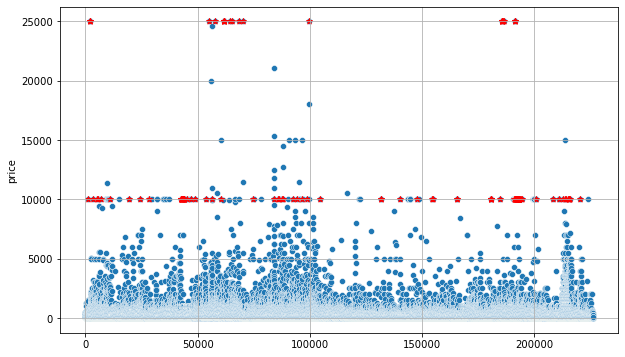

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, y='price', x=df.index)
plt.scatter(strange.index,strange['price'], color='r', marker='*')
plt.grid()

Keeping 92.52% of the dataset


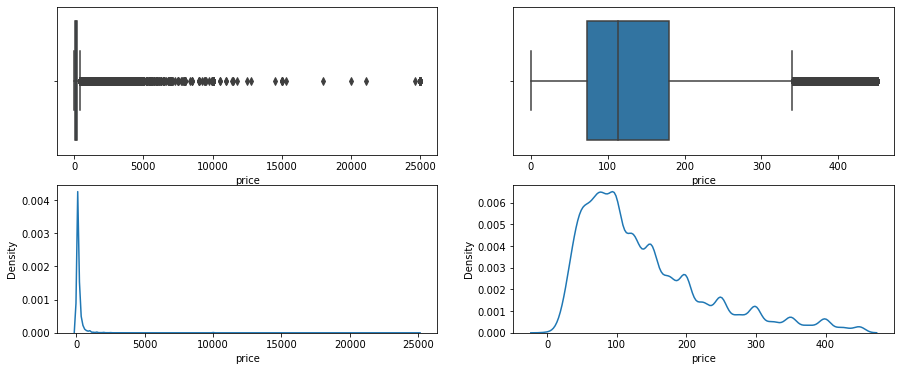

In [14]:

fig, ax = plt.subplots(2,2, figsize=(15,6))
sns.boxplot(data=df, x='price', ax=ax[0,0])
sns.kdeplot(data=df, x='price', ax=ax[1,0]);

# Countering Outliers
def quantile_selector(df, bounds):
    df_reduced = df[df['price'].between(df['price'].quantile(bounds[0]), df['price'].quantile(bounds[1]), inclusive=True)]
    print(f'Keeping {round(len(df_reduced)/len(df)*100,2)}% of the dataset')
    return df_reduced

bounds = [0.0, 0.925]
df = quantile_selector(df, bounds)

sns.boxplot(data=df, x='price', ax=ax[0,1])
sns.kdeplot(data=df, x='price', ax=ax[1,1]);

In [15]:
feat_num = df.select_dtypes(include=['float','int']).drop(columns=['latitude', 'longitude']).columns
feat_num

Index(['reviews_per_month'], dtype='object')

0.02% minimum_nights values are above 15!


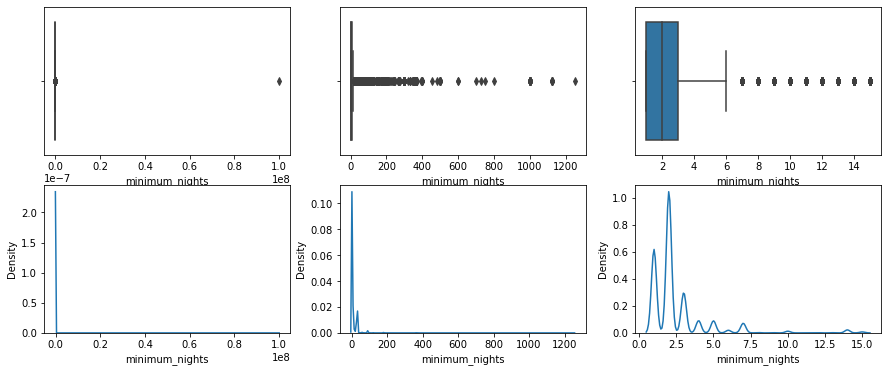

In [16]:
fig, ax = plt.subplots(2,3, figsize=(15,6))
sns.boxplot(data=df, x='minimum_nights', ax=ax[0,0])
sns.kdeplot(data=df, x='minimum_nights', ax=ax[1,0]);

# First Step
df_red = df[df['minimum_nights']<1e8]

sns.boxplot(data=df_red, x='minimum_nights', ax=ax[0,1])
sns.kdeplot(data=df_red, x='minimum_nights', ax=ax[1,1]);

anomalies = df[feat_num[0]]>15
print(f'{round(len(df[anomalies])/len(df)*100, 2)}% minimum_nights values are above 15!')

# Second Step
def nan_converter(x, value):
    if x > value:
        return np.nan
    return x

df['minimum_nights'] = df['minimum_nights'].copy().apply(lambda x: nan_converter(x, 15))

simple_impute = SimpleImputer(strategy='median')
df['minimum_nights'] = simple_impute.fit_transform(df[['minimum_nights']])

sns.boxplot(data=df, x='minimum_nights', ax=ax[0,2])
sns.kdeplot(data=df, x='minimum_nights', ax=ax[1,2]);

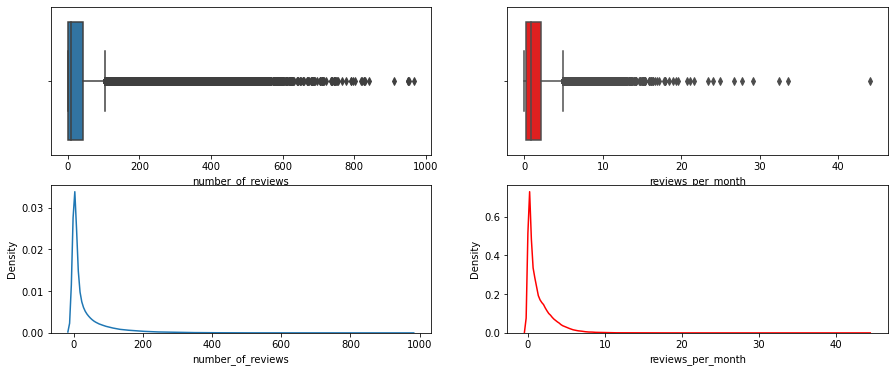

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,6))
sns.boxplot(data=df, x='number_of_reviews', ax=ax[0,0])
sns.boxplot(data=df, x='reviews_per_month', ax=ax[0,1], color='r')
sns.kdeplot(data=df, x='number_of_reviews', ax=ax[1,0])
sns.kdeplot(data=df, x='reviews_per_month', ax=ax[1,1], color='r');

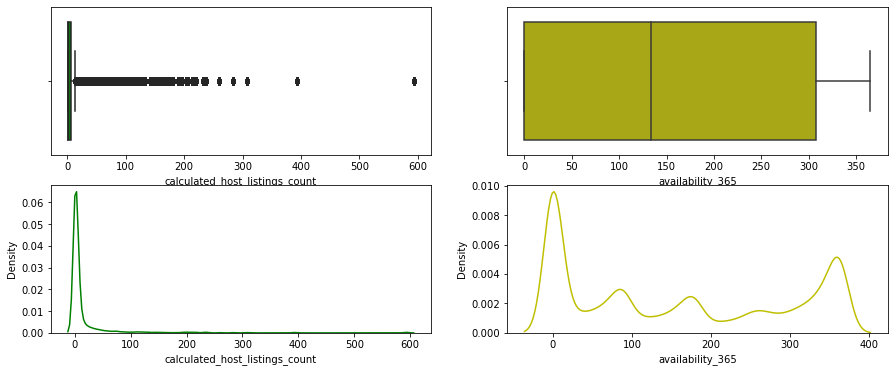

In [18]:
fig, ax = plt.subplots(2,2, figsize=(15,6))
sns.boxplot(data=df, x='calculated_host_listings_count', ax=ax[0,0], color='g')
sns.boxplot(data=df, x='availability_365', ax=ax[0,1], color='y')
sns.kdeplot(data=df, x='calculated_host_listings_count', ax=ax[1,0], color='g')
sns.kdeplot(data=df, x='availability_365', ax=ax[1,1], color='y');

In [19]:
df = pd.read_csv('AB_US_2020.csv')
df.head(1)

C:\Users\perso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville


In [20]:
dropped_feat = ['last_review','name', 'latitude', 'longitude',
                'id','host_id','host_name', 'neighbourhood']
df = df.drop(columns=dropped_feat)

In [21]:
# Quantile Selection
bounds = [0.0, 0.925]

def quantile_selector(df, bounds):
    df_reduced = df[df['price'].between(df['price'].quantile(bounds[0]), df['price'].quantile(bounds[1]), inclusive=True)]
    print(f'Keeping {round(len(df_reduced)/len(df)*100,2)}% of the dataset')
    return df_reduced

df = quantile_selector(df, bounds)

Keeping 92.52% of the dataset


In [22]:
X = df.drop(columns='price')
y = df['price']

In [24]:
# # Strong Impact
# class QuantileSelector(TransformerMixin, BaseEstimator): 

#     def __init__(self, target, bounds):
#         self.bounds = bounds
#         self.target = target
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         df = pd.concat([X, self.target], axis=1)
#         df_reduced = df[df['price'].between(df['price'].quantile(bounds[0]), df['price'].quantile(bounds[1]), inclusive=True)]
#         print(f'Keeping {round(len(df_reduced)/len(df)*100,2)}% of the dataset')
#         X = df_reduced.drop(columns='price')
#         return X


In [23]:
X.columns

Index(['neighbourhood_group', 'room_type', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'city'],
      dtype='object')

In [25]:
# Very Strong Impact
# class NANConverter(TransformerMixin, BaseEstimator): 

#     def __init__(self, threshold, col_name, greater=True):
#         self.threshold = threshold
#         self.col_name = col_name
#         self.greater = greater
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         import pdb; pdb.set_trace()
#         if self.greater:
#             cond = X[self.col_name]>self.threshold
#             X.loc[cond, self.col_name] = np.nan
#         else:
#             cond = X[self.col_name]<self.threshold
#             X.loc[cond, self.col_name] = np.nan
#         return X


In [26]:
def NANConvert(x, threshold):
    if x>threshold:
        return np.nan
    return x

X['minimum_nights'] = X['minimum_nights'].apply(lambda x: NANConvert(x, 15))

In [27]:
X.dtypes.value_counts()

int64      3
object     3
float64    2
dtype: int64

In [28]:
# Converting Availability 0 into median value
def ValueConvert(x, threshold, value):
    if x==threshold:
        return value
    return x

median = round(np.mean(X['availability_365']))

X['availability_365'] = X['availability_365'].apply(lambda x: ValueConvert(x, 0, median))

In [29]:
def to_month(x):
    if x < 30:
        return '1'

    elif 30 <= x <60:
        return '2'
    
    elif 60 <= x <90:
        return '3'
    
    elif 90 <= x <120:
        return '4'
    
    elif 120 <= x <150:
        return '5'
    
    elif 150 <= x <170:
        return '6'
    
    elif 170 <= x <200:
        return '7'
    
    elif 230 <= x <250:
        return '8'
    
    elif 250 <= x <270:
        return '9'
    
    elif 270 <= x <300:
        return '10'
    
    elif 300 <= x <330:
        return '11'
    
    else:
        return '12'
    
X['availability_365'] = X['availability_365'].apply(to_month)

In [30]:
X.dtypes.value_counts()

object     4
int64      2
float64    2
dtype: int64

In [31]:
num_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value=1)),
                        ('rob_scaler', RobustScaler())])

cat_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
                        ('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


preproc = ColumnTransformer([('num_encoder', num_encoder, make_column_selector(dtype_include=['int64','float64'])),
                             ('cat_encoder', cat_encoder , make_column_selector(dtype_include=['object']))
                              ])

baseline_pipe = Pipeline([('preprocessing', preproc),
                          ('model', Ridge())
                        ])
baseline_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('rob_scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF9DA11A30>),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AF9DA112E0>)])),
                ('model', Ridge())])

In [32]:
rsme = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

In [33]:
baseline_score = cross_val_score(baseline_pipe, X, y, cv=5).mean()
baseline_score

0.22211726840037768

In [34]:
df = pd.read_csv('AB_US_2020.csv')

C:\Users\perso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
len(df)

226030

In [36]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')

In [37]:
df.neighbourhood_group.unique()

array([nan, 'Hawaii', 'Kauai', 'Maui', 'Honolulu', 'Other Cities',
       'City of Los Angeles', 'Unincorporated Areas', 'Manhattan',
       'Brooklyn', 'Queens', 'Staten Island', 'Bronx', 'Providence',
       'Washington', 'Newport', 'Bristol', 'Kent', 'Central Area',
       'Other neighborhoods', 'West Seattle', 'Downtown', 'Ballard',
       'Capitol Hill', 'Beacon Hill', 'Seward Park', 'Queen Anne',
       'Rainier Valley', 'Lake City', 'Cascade', 'Delridge',
       'University District', 'Northgate', 'Magnolia', 'Interbay'],
      dtype=object)

In [38]:
dropped_feat = ['id','host_id','host_name', 'neighbourhood']
df = df.drop(columns=dropped_feat)

In [39]:
df.city.unique()

array(['Asheville', 'Austin', 'Boston', 'Broward County', 'Cambridge',
       'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii',
       'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans',
       'New York City', 'Oakland', 'Pacific Grove', 'Portland',
       'Rhode Island', 'Salem', 'San Clara Country', 'San Diego',
       'San Francisco', 'San Mateo County', 'Santa Cruz County',
       'Seattle', 'Twin Cities MSA', 'Washington D.C.'], dtype=object)

In [40]:
df[df.city == 'Hawaii'].neighbourhood_group.unique()

array(['Hawaii', 'Kauai', 'Maui', 'Honolulu'], dtype=object)

In [41]:
df[df.city == 'New York City'].neighbourhood_group.unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [42]:
df[df.city == 'Rhode Island'].neighbourhood_group.unique()

array(['Providence', 'Washington', 'Newport', 'Bristol', 'Kent'],
      dtype=object)

In [43]:
center_coordinates = {'Asheville': [35.595058, -82.551487, 'NC'],
                      'Austin': [30.266666, -97.733330, 'TX'],
                      'Boston': [42.361145, -71.057083, 'MA'],
                      'Broward County': [26.1244, -80.2495, 'Florida'],
                      'Cambridge': [42.373611, -71.110558,'MA'],
                      'Chicago': [41.881832, -87.623177,'IL'],
                      'Clark County': [36.114647, -115.172813, 'NV'], 
                      'Columbus': [39.983334, -82.983330,'OH'],
                      'Denver': [39.742043,  -104.991531, 'CO'],
                      'Hawaii': [19.8968, -155.5828, 'HI'],
                      'Kauai': [22.108543, -159.496765, 'HI'],
                      'Maui': [20.798363, -156.331924, 'HI'],
                      'Honolulu': [21.315603, -157.858093,'HI'],
                      'Jersey City': [40.719074, -74.050552,'NJ'],
                      'Los Angeles': [34.052235, -118.243683, 'CA'],
                      'Nashville': [36.174465, -86.767960, 'TN'],
                      'New Orleans': [29.951065, -90.071533, 'LA'],
                      'Manhattan': [40.754932, -73.984016, 'NY'],
                      'Brooklyn': [40.650002, -73.949997, 'NY'],
                      'Queens': [40.742054, -73.769417, 'NY'],
                      'Staten Island': [40.579021, -74.151535, 'NY'],
                      'Bronx': [40.837048, -73.865433, 'NY'],
                      'Oakland': [37.804363, -122.271111, 'CA'],
                      'Pacific Grove': [36.617779, -121.916664, 'CA'],
                      'Portland': [45.523064, -122.676483, 'OR'],
                      'Providence': [41.825226, -71.418884, 'RI'],
                      'Washington': [41.6884336, -71.5667291, 'RI'],
                      'Newport': [41.490578, -71.310196, 'RI'],
                      'Bristol': [41.6771101,  -71.2662025, 'RI'],
                      'Kent': [41.6800, -71.5800, 'RI'],
                      'Salem': [44.944099, -123.040283, 'OR'],
                      'San Clara Country': [37.354107, -121.955238, 'CA'],
                      'San Diego': [32.715736, -117.161087, 'CA'],
                      'San Francisco': [37.773972, -122.431297, 'CA'],
                      'San Mateo County': [37.554169, -122.313057, 'CA'],
                      'Santa Cruz County': [36.974117, -122.030792, 'CA'],
                      'Seattle': [47.608013, -122.335167, 'WA'],
                      'Twin Cities MSA': [44.986656, -93.258133, 'MN'],
                      'Washington D.C.': [38.89511, -77.03637, 'DC']}           
                      

In [44]:
# BAD COODING !
def city_convert(city, neigh):
    res = []
    for cit, nei in zip(city, neigh):
        if cit == 'Hawaii' or cit == 'New York City' or cit == 'Rhode Island':
            res.append(nei)
        else:
            res.append(cit)
    return res

df['city'] = city_convert(df.city, df.neighbourhood_group)

In [45]:
df['city'].unique()

array(['Asheville', 'Austin', 'Boston', 'Broward County', 'Cambridge',
       'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii', 'Kauai',
       'Maui', 'Honolulu', 'Jersey City', 'Los Angeles', 'Nashville',
       'New Orleans', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island',
       'Bronx', 'Oakland', 'Pacific Grove', 'Portland', 'Providence',
       'Washington', 'Newport', 'Bristol', 'Kent', 'Salem',
       'San Clara Country', 'San Diego', 'San Francisco',
       'San Mateo County', 'Santa Cruz County', 'Seattle',
       'Twin Cities MSA', 'Washington D.C.'], dtype=object)

In [46]:
# BAD COODING !
def city_coordinates(city, center_coordinates):
    #import pdb; pdb.set_trace()
    city_lat = []
    city_lon = []
    city_state = []
    for cit in city:
        res = center_coordinates[cit]
        city_lat.append(res[0])
        city_lon.append(res[1])
        city_state.append(res[2])
    return city_lat, city_lon, city_state

df['city_lat'], df['city_lon'], df['city_state'] = city_coordinates(df.city, center_coordinates)

In [47]:
df.columns

Index(['name', 'neighbourhood_group', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city', 'city_lat', 'city_lon', 'city_state'],
      dtype='object')

In [48]:
def haversine_vectorized(df,
                         start_lat="city_lat",
                         start_lon="city_lon",
                         end_lat="latitude",
                         end_lon="longitude"):

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)),\
        np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)),\
        np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) *\
        np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

In [49]:
df['distance'] = haversine_vectorized(df)

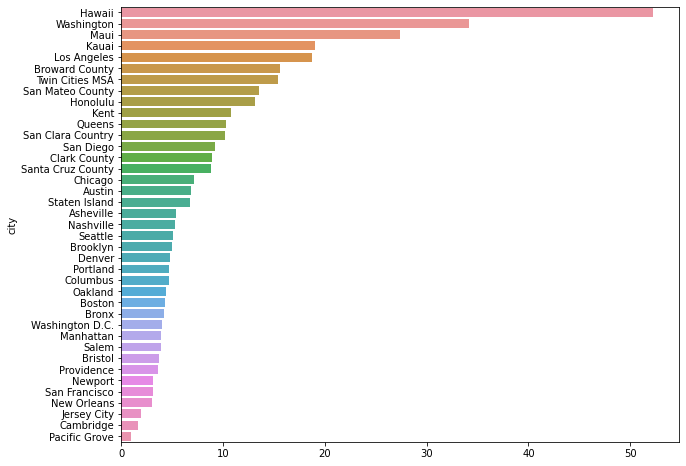

In [50]:
average_distance = df.groupby('city').mean()['distance'].sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(y = average_distance.index, x=average_distance.values);

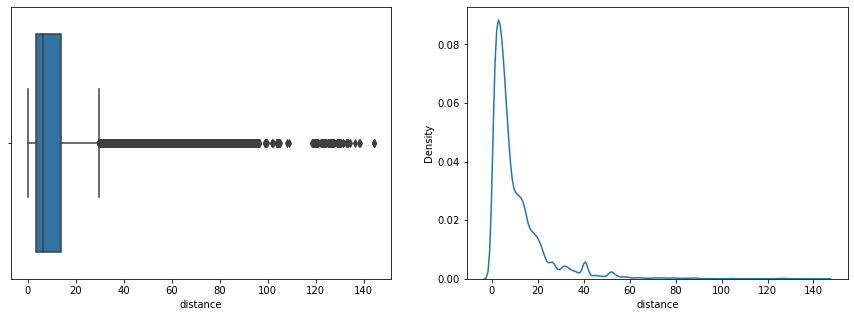

In [51]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=df, x='distance', ax=ax[0])
sns.kdeplot(data=df, x='distance', ax=ax[1]);

In [52]:
dropped_feat = ['last_review','name', 'latitude', 'longitude', 'city_lat', 'city_lon', 'neighbourhood_group']
df = df.drop(columns=dropped_feat)

In [53]:
df.columns

Index(['room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city', 'city_state', 'distance'],
      dtype='object')

In [54]:
# Quantile Selection
bounds = [0.0, 0.925]

def quantile_selector(df, bounds):
    df_reduced = df[df['price'].between(df['price'].quantile(bounds[0]), df['price'].quantile(bounds[1]), inclusive=True)]
    print(f'Keeping {round(len(df_reduced)/len(df)*100,2)}% of the dataset')
    return df_reduced

df = quantile_selector(df, bounds)

X = df.drop(columns='price')
y = df['price']

def NANConvert(x, threshold):
    if x>threshold:
        return np.nan
    return x

X['minimum_nights'] = X['minimum_nights'].apply(lambda x: NANConvert(x, 15))


# Converting Availability 0 into median value
def ValueConvert(x, threshold, value):
    if x==threshold:
        return value
    return x

median = round(np.mean(X['availability_365']))

X['availability_365'] = X['availability_365'].apply(lambda x: ValueConvert(x, 0, median))


def to_month(x):
    if x < 30:
        return '1'

    elif 30 <= x <60:
        return '2'
    
    elif 60 <= x <90:
        return '3'
    
    elif 90 <= x <120:
        return '4'
    
    elif 120 <= x <150:
        return '5'
    
    elif 150 <= x <170:
        return '6'
    
    elif 170 <= x <200:
        return '7'
    
    elif 230 <= x <250:
        return '8'
    
    elif 250 <= x <270:
        return '9'
    
    elif 270 <= x <300:
        return '10'
    
    elif 300 <= x <330:
        return '11'
    
    else:
        return '12'
    
X['availability_365'] = X['availability_365'].apply(to_month)

Keeping 92.52% of the dataset


In [55]:

from sklearn.svm import SVR

num_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value=1)),
                        ('rob_scaler', RobustScaler())])

cat_encoder = Pipeline([('simple_imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
                        ('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


preproc = ColumnTransformer([('num_encoder', num_encoder, make_column_selector(dtype_include=['int64','float64'])),
                             ('cat_encoder', cat_encoder , make_column_selector(dtype_include=['object']))
                              ])

baseline_pipe = Pipeline([('preprocessing', preproc),
                          ('model', Ridge())
                        ])
baseline_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('rob_scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFA9DE30D0>),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AFA9DE3820>)])),
                ('model', Ridge())])

In [56]:

baseline_score = cross_val_score(baseline_pipe, X, y, cv=5).mean()
baseline_score

0.22335561204416568